# [Optimized Model Experiment & Result Analysis]

In this notebook, user can compare optimized models with originals and each others

experiments conditions:
- 3 kinds of models (Extra Tree Regressor, RandomForest Regressor, XGBoost Regressor)
- K-fold : 10
- Evaluating Metrics : R-Squared, MAE, RMSE
- Evaluating Dataset : Test

## Import Library, Module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import pickle

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from xgboost import plot_tree
from sklearn.tree import plot_tree

import shap

In [67]:
# import machine learning algorithms

from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.ensemble import ExtraTreesRegressor

---
## Data Load

In [9]:
# set the route for dataset
# route = "./2023_KSW_Fall_program_final_team_HoT/4+6_Imputation+5_Feature_Scaling(final_dataset).csv"

route = "./Dataset/2023_KSW_Fall_program_final_team_HoT/4+6_Imputation+5_Feature_Scaling(final_dataset).csv"

# set ratio for splitting train/test dataset
test_size = 0.33
shuffle = True

# set the K for cross-validation
k_splits = 10

In [10]:
# data_load function for preparing dataset
# user can remove the specific feature by setting remove_list parameter

def data_loader(route, remove_list):
    # load dataset from route user set above
    original_data = pd.read_csv(route, encoding='unicode_escape')
    
    # drop index
    original_data = original_data.drop(original_data.columns[0], axis=1)
    
    # drop timestamps (depending on dataset, there is timestamp column)
    # original_data = original_data.drop(original_data.columns[0], axis=1)

    # drop features in remove_list
    for i in remove_list:
        original_data = original_data.drop([i], axis=1)
    
    # drop Nan values - feature by feature
    original_data = original_data.dropna()
    
    # check data shape
    print(original_data.shape)
    
    # set x, y dataset
    # y is the SP ratio, which is the target
    y = original_data[['SP ratio']].squeeze().to_numpy()
    x = original_data.drop(['SP ratio'], axis=1).to_numpy()
    
    return x, y

In [11]:
# make a list to remove features in dataset as selected through dataset selection part
# what features are used : hr, hrv, BM, sleep, eda, temperature

removed_features = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'coherence']
x, y = data_loader(route, removed_features)

(12358, 7)


In [12]:
# Split train dataset, test dataset

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = test_size, shuffle = shuffle)

In [14]:
# check the shape of dataset

print(x.shape)
print(y.shape)

(12358, 6)
(12358,)


---
## Model Training

In [31]:
# create KFold object for cross validation
# In our experiments, we test 2 cases : k=5, k=10

k_fold = KFold(n_splits=k_splits, random_state=1, shuffle=True)

In [34]:
# training 1 model

def model_trainer(model, X_train, X_test, y_train, y_test):
    i=1
    
    # create lists for 3 types of metrics
    r2_scr = []
    rmse_scr = []
    mae_scr = []
    
    # Splitting train dataset into train, valid dataset using k-fold
    for train_index, val_index in k_fold.split(np.zeros(len(X_train)), y_train):
        X_train_fold, X_val_fold = X_train[train_index,:], X_train[val_index,:]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
        # fit the regressor with train data
        model.fit(X_train_fold, y_train_fold)

        # validation for model with validation dataset
        val_labels = np.expm1(y_val_fold)
        val_pred = np.expm1(model.predict(X_val_fold))
        
        # appending evluation values for each fold 
        r2_scr.append(r2_score(val_labels, val_pred))
        mae_scr.append(mean_absolute_error(val_labels, val_pred))
        rmse_scr.append(mean_squared_error(val_labels, val_pred, squared=False))

        i+=1
        
    # return model and evaluation metrics as a mean value exept r2 (to draw graph)
    return model, r2_scr, np.average(mae_scr), np.average(rmse_scr)

In [35]:
# training 6 models

def training(X_train, X_test, y_train, y_test):
    
    # Original models (without Optimization)
    etr_origin = ExtraTreesRegressor()
    rf_origin = RandomForestRegressor()
    xgbr_origin = xg.XGBRegressor()

    # Optimized models
    etr_op = ExtraTreesRegressor(criterion='friedman_mse', max_depth=None, max_features=1.0, min_samples_split=2, n_estimators=350)
    rf_op = RandomForestRegressor(n_estimators=150, criterion='friedman_mse', max_depth=None, max_features=1.0, min_samples_split=2)
    xgbr_op = xg.XGBRegressor(n_estimators = 200, eta=0.1, eval_metric='rmse', max_depth=9, reg_lambda=1.0)
    
    # train each model
    etr_origin, r2_etr_origin, mae_etr_origin, rmse_etr_origin = model_trainer(etr_origin, X_train, X_test, y_train, y_test)
    rf_origin, r2_rf_origin, mae_rf_origin, rmse_rf_origin = model_trainer(rf_origin, X_train, X_test, y_train, y_test)
    xgbr_origin, r2_xgbr_origin, mae_xgbr_origin, rmse_xgbr_origin = model_trainer(xgbr_origin, X_train, X_test, y_train, y_test)
    
    etr_op, r2_etr_op, mae_etr_op, rmse_etr_op = model_trainer(etr_op, X_train, X_test, y_train, y_test)
    rf_op, r2_rf_op, mae_rf_op, rmse_rf_op = model_trainer(rf_op, X_train, X_test, y_train, y_test)
    xgbr_op, r2_xgbr_op, mae_xgbr_op, rmse_xgbr_op = model_trainer(xgbr_op, X_train, X_test, y_train, y_test)
    
    # set the x axis for plot
    x = np.arange(k_splits)
  
    # Visualizing by making plot 6 models' R-Squared score trends for each fold
    plt.plot(x, r2_etr_origin, label = "ExtraTree_origin")
    plt.plot(x, r2_rf_origin, label = "RandomForest_origin")
    plt.plot(x, r2_xgbr_origin, label = "XGBR_origin")
    plt.plot(x, r2_etr_op, label = "ExtraTree")
    plt.plot(x, r2_rf_op, label = "RandomForest")
    plt.plot(x, r2_xgbr_op, label = "XGBR")
    plt.legend() 
    plt.show()
    
    # store each metrics for each model
    r2 = [r2_etr_origin, r2_rf_origin, r2_xgbr_origin, r2_etr_op, r2_rf_op, r2_xgbr_op]
    mae = [mae_etr_origin, mae_rf_origin, mae_xgbr_origin, mae_etr_op, mae_rf_op, mae_xgbr_op]
    rmse = [rmse_etr_origin, rmse_rf_origin, rmse_xgbr_origin, rmse_etr_op, rmse_rf_op, rmse_xgbr_op]
    
    # return each metrics as a mean values and models
    return np.mean(r2 , axis=1), mae, rmse, [etr_origin, rf_origin, xgbr_origin, etr_op, rf_op, xgbr_op]

### Training 6 models

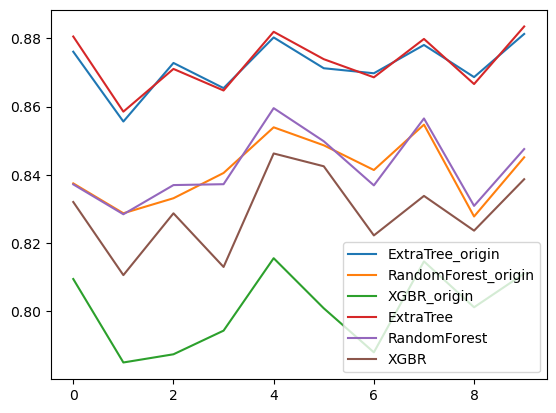

In [49]:
r2_scores, mae_scores, rmse_scores, models = training(X_train, X_test, y_train, y_test)

etr_origin, rf_origin, xgbr_origin, etr_op, rf_op, xgbr_op = models[0], models[1], models[2], models[3], models[4], models[5]

In [50]:
# make model list to print scores easily
models = ['etr_origin', 'rf_origin', 'xgb_origin', 'etr_op', 'rf_op', 'xgb_op']

In [56]:
# R-Squared for each model with train dataset

print("R-Sqaured")
print("---------"*3)
for i in range(6):
    print('%s %s: %f' % (models[i], '\t', r2_scores[i]))

R-Sqaured
---------------------------
etr_origin 	: 0.871925
rf_origin 	: 0.841152
xgb_origin 	: 0.800735
etr_op 	: 0.872922
rf_op 	: 0.842115
xgb_op 	: 0.829149


In [55]:
# MAE for each model with train dataset

print("MAE")
print("---------"*3)
for i in range(6):
    print('%s %s: %f' % (models[i], '\t', mae_scores[i]))

MAE
---------------------------
etr_origin 	: 0.058155
rf_origin 	: 0.065286
xgb_origin 	: 0.076319
etr_op 	: 0.057874
rf_op 	: 0.064897
xgb_op 	: 0.069223


In [54]:
# RMSE for each model with train dataset

print("RMSE")
print("---------"*3)
for i in range(6):
    print('%s %s: %f' % (models[i], '\t', rmse_scores[i]))

RMSE
---------------------------
etr_origin 	: 0.085245
rf_origin 	: 0.094923
xgb_origin 	: 0.106373
etr_op 	: 0.084910
rf_op 	: 0.094638
xgb_op 	: 0.098459


## => Final Model : Optimized Extra Tree Regressor

---
## Feature Importance

visualizing the feature importance for each model

In [57]:
def draw_feature_importance_plot(model, name):
    ind = ['HR', 'HRV', 'Body Movement', 'Sleep', 'EDA', 'Temperature']

    global_importances = pd.Series(model.feature_importances_, index=ind)
    global_importances.sort_values(ascending=True, inplace=True)
    plt.figure(figsize=(6, 4))
    global_importances.plot.barh(color='olive')
    plt.xlabel("Importance", fontdict={'fontsize':15})
    plt.ylabel("Feature", fontdict={'fontsize':15})
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    title = name + " - Feature Importance"
    plt.title(title, fontdict={'fontsize':20})

#### 1) Extra Tree Regressor - Feature Importance

In [69]:
# view model's feature importance values

etr_op.feature_importances_

array([0.08841831, 0.11125869, 0.19249141, 0.18663294, 0.22170871,
       0.19948994])

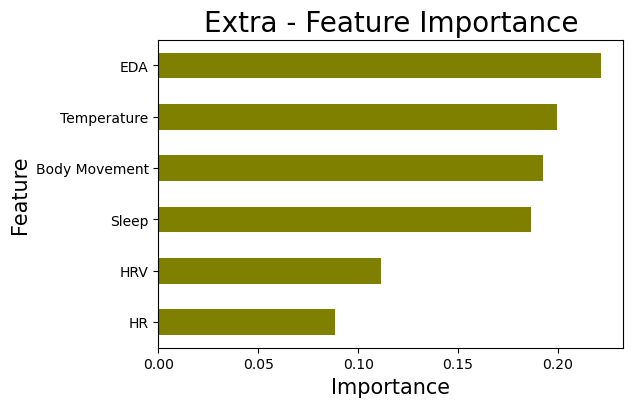

In [59]:
draw_feature_importance_plot(etr_op, "Extra")

#### 2) Random Forest Regressor - Feature Importance

In [64]:
# view model's feature importance values

rf_op.feature_importances_

array([0.08093285, 0.14086017, 0.1589312 , 0.1642088 , 0.24834918,
       0.20671779])

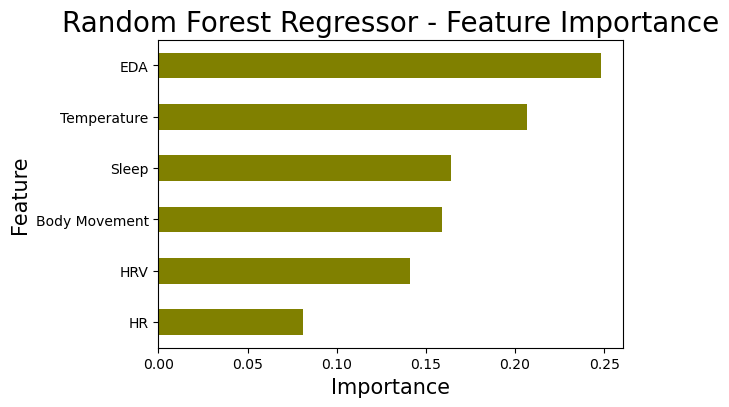

In [62]:
draw_feature_importance_plot(rf_op, "Random Forest Regressor")

#### 3) XGBoost Regressor - Feature Importance

In [66]:
# view model's feature importance values

xgbr_op.feature_importances_

array([0.02768763, 0.05871207, 0.24408327, 0.441456  , 0.12529536,
       0.10276572], dtype=float32)

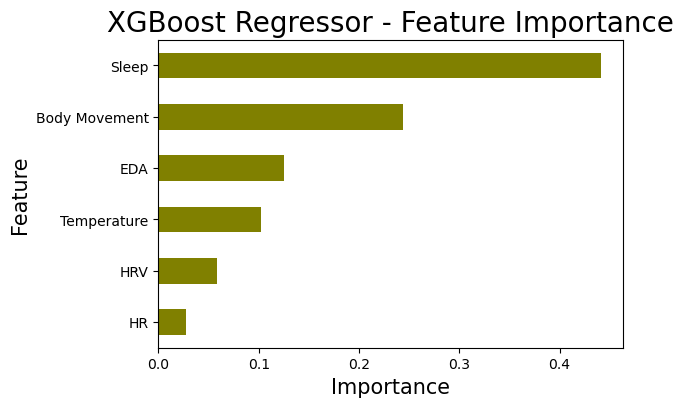

In [68]:
from xgboost import plot_importance

draw_feature_importance_plot(xgbr_op, "XGBoost Regressor")

### Visualization using SHAP

a tool to interpret black-box models that have nontransparent internal structures

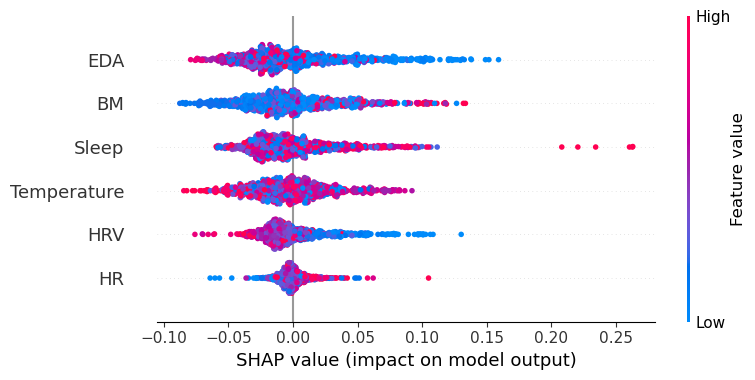

In [73]:
# top 1000 

# set SHAP explainer
explainer = shap.Explainer(etr_op)

# generate for SHAP value
# select data to calculate shap value
data_for_shap = X_test[1000:2000]

# calculate SHAP
shap_values = explainer.shap_values(data_for_shap)

feature_names = ['HR', 'HRV', 'BM', 'Sleep', 'EDA', 'Temperature']

# visualization
shap.summary_plot(shap_values, features=data_for_shap, feature_names=feature_names)

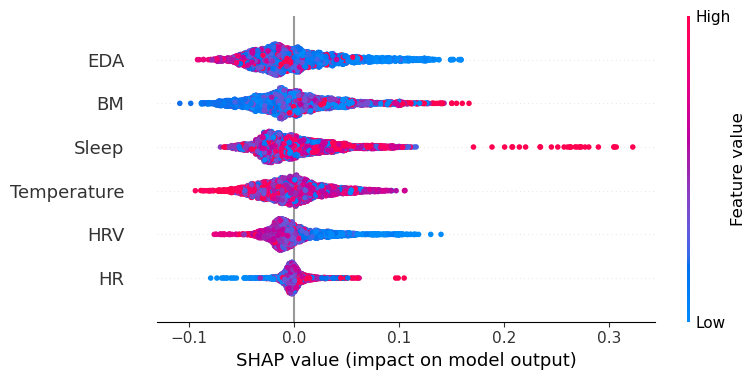

In [74]:
# whole data

# set SHAP explainer
explainer = shap.Explainer(etr_op)

# generate for SHAP value
# select data to calculate shap value
data_for_shap = X_test

# calculate SHAP
shap_values = explainer.shap_values(data_for_shap)

feature_names = ['HR', 'HRV', 'BM', 'Sleep', 'EDA', 'Temperature']

# visualization
shap.summary_plot(shap_values, features=data_for_shap, feature_names=feature_names)

### Visualization using LIME

provides interpretable explanations for the predictions of complex models by approximating their decision boundaries in the local vicinity of a specific instance.

In [505]:
# 11th instance

X_test[10]

array([ 0.15104364,  0.5852768 ,  0.35761589,  0.71698113,  0.2015985 ,
       -1.17768775])

In [664]:
from lime.lime_tabular import LimeTabularExplainer

feature_names = ['HR', 'HRV', 'BM', 'Sleep', 'EDA', 'Temperature']

# set LimeTabularExplainer
explainer = LimeTabularExplainer(training_data=np.array(X_train), feature_names=feature_names, mode='regression')

# select sample that user want to explain
# in this case, select 86th instance
sample = X_test[85]

# create explanation using Lime
explanation = explainer.explain_instance(sample, etr_op.predict, num_features=len(feature_names))

# print explanation
explanation.show_in_notebook()

In [512]:
# print feature contribution

pd.DataFrame(explanation.as_list(),columns=['Feature','Contribution'])

,Feature,Contribution
0,EDA > 0.49,-0.021023
1,0.01 < Temperature <= 0.88,0.012923
2,Sleep > 0.64,0.012346
3,0.07 < BM <= 0.13,-0.011503
4,HRV > 0.44,-0.011013
5,HR <= 0.12,-0.003305


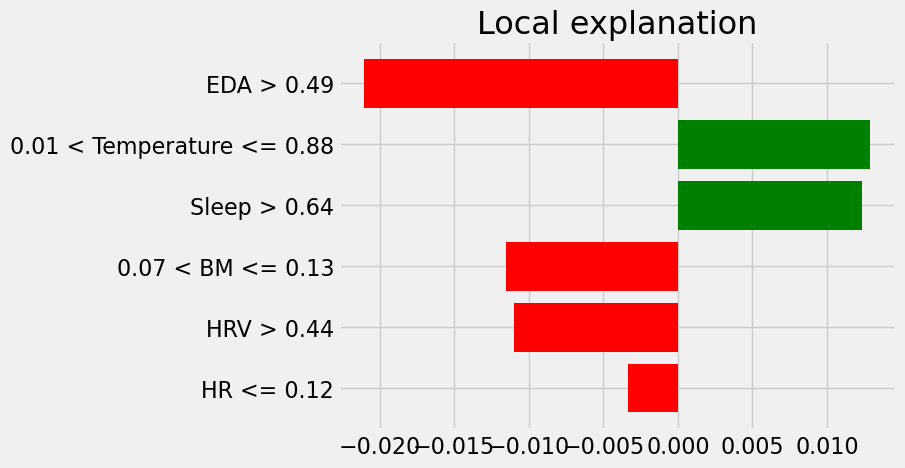

In [513]:
# variable level contribution
%matplotlib inline
fig = explanation.as_pyplot_figure(label=1)

---
## Evaluation with Test dataset

To check model's performance, user can print R-Squared score, MAE, RMSE

In [87]:
def tester(model, X_test, y_test):

    # y_label
    val_labels = np.expm1(y_test)
    # y_predict
    val_pred = np.expm1(model.predict(X_test))
    
    # data post-processing (clipping)
    val_pred_clipped = np.clip(val_pred, 0, 1)

    # comparison evaluation for test dataset
    r2_scr_t = r2_score(val_labels, val_pred_clipped)
    mae_scr_t = mean_absolute_error(val_labels, val_pred)
    rmse_scr_t = mean_squared_error(val_labels, val_pred_clipped, squared=False)
        
    return model, r2_scr_t, mae_scr_t, rmse_scr_t

In [102]:
# print each model test performance result

models = [etr_origin, rf_origin, xgbr_origin, etr_op, rf_op, xgbr_op]
model_names = ['etr_origin', 'rf_origin', 'xgbr_origin', 'etr_op', 'rf_op', 'xgbr_op']
testers = []

for model in models:
    testers.append(tester(model, X_test, y_test))
    
for metr in range(1,4):
    if metr==1:
        print("R-Squared")
    elif metr==2:
        print("MAE")
    else:
        print("RMSE")
    print("----"*10)
    for model in range(len(testers)):
        print(model_names[model], ' : ', testers[model][metr])
    print("----"*10)

R-Squared
----------------------------------------
etr_origin  :  0.8527804485942415
rf_origin  :  0.8305561568935835
xgbr_origin  :  0.796338709782058
etr_op  :  0.8567189168220808
rf_op  :  0.8296244769492432
xgbr_op  :  0.8206627457724901
----------------------------------------
MAE
----------------------------------------
etr_origin  :  0.059921357598765185
rf_origin  :  0.06597986790242737
xgbr_origin  :  0.07709480286718814
etr_op  :  0.05919915977248592
rf_op  :  0.06618267367048322
xgbr_op  :  0.06910033682407934
----------------------------------------
RMSE
----------------------------------------
etr_origin  :  0.09366654838438453
rf_origin  :  0.10048810773593438
xgbr_origin  :  0.11016813998146667
etr_op  :  0.09240515497816051
rf_op  :  0.10076399386523018
xgbr_op  :  0.10338011948903549
----------------------------------------


### model save

In [104]:
# save the model to disk
filename = 'best_model(etr).pkl'
pickle.dump(etr_op, open(filename, 'wb'))

In [105]:
filename = './best_model(etr).pkl'

In [109]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model.fit(X_train, y_train)

# result = loaded_model.score(X_test, y_test)
# result

0.877192563156463